<span style="font-family:Papyrus; font-size:3em;">BIOE 437 Midterm</span>

<span style="font-family:Papyrus; font-size:2em;">Design of Experiments</span>

# Problem

BioModels model 45 shows bursting behavior of Calcium oscillations using the chemical species ``EC``, ``X``, ``Y``, and ``Z``.
Factors affecting the Ca oscillations include the initial concentrations of these four chemical species.
In this problem, you will find levels of these factors such that:
1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
1. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
1. All concentrations of the chemical species are non-negative in the simulation.

There are three parts to answering this question.

1. (20 pts) **Design of Experiments**. What is your experimental design? That is: (a) what is the baseline; (b) what are the factors; (c) what are the levels of the factors; and (d) what $n$WD did you use.
Explain why you chose the particular levels and $n$. It may be that you use a "mixed" strategy in which you
do initial experiments with one design, and based on these outcomes, you do a new design.

1. (60 pts) **Experimental Infrastructure**. Implement the following functions.
As always, you should have documentation and tests for each function.
Note that BioModels 45 is the file ``BIOMD0000000045_url.xml`` in the ``common`` directory. (See code below.)

   1. ``runExperiment`` runs an experiment for levels of initial values of chemical species and returns
   the result of the simulation. The function optionally
   plots the results. 
   1. ``getResponse`` calculates the the
   values of the frequency with the largest amplitude (along with the amplitude) for a chemical species over a
   designated time interval.
   1. ``runStudy`` runs a set of experiments, checking for combinations of factor levels that match the
   objectives of this study. You should show the results of your search for levels of factors and that the levels
   you select satisfy the conditions of the problem by doing a plot.
  
   Hint: You may find that the codes in the *Helpers* subsection are useful for you, but you are not required to use these codes.
    
1. (20 pts) **Studies and Analysis**. Describe the studies you conducted, showing how you found a combination of factor levels that meet the requirements.

Please put your answers to these questions in the separate sections below.

# Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
import itertools
import seaborn as sns

import matplotlib.gridspec as gridspec
from scipy import fftpack
import tellurium as te

## Model

In [2]:
ROADRUNNER = te.loadSBMLModel(
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

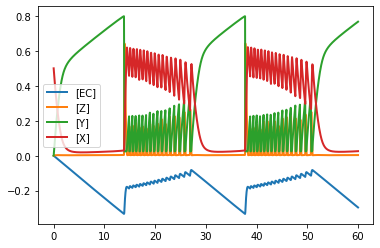

In [3]:
ROADRUNNER.plot(ROADRUNNER.simulate(0,60, 1200))

## Constants

In [4]:
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value
TIME_OFFSET = 150

# Simulation constants
START_TIME = 0  # Start time for the simulation
END_TIME = 60  # End time for the simulation
BURST_DCT = {0: (15, 25), 1: (40, 50)}  # Where bursts should be preserved
NUM_POINT = 10*(END_TIME - START_TIME)  # Number of points in output
PARAMETERS = ["X", "Y", "Z", "EC"]
TIME = "time"

## Helpers

In [5]:
def arrToDF(arr, isSimulation=True):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    if isSimulation:
        df = df.set_index(TIME)
    return df

# Tests
arr = ROADRUNNER.simulate()
df = arrToDF(arr)
assert(len(df) > 0)
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [6]:
def runSimulation(parameterDct=None, roadrunner=ROADRUNNER,numPoint=NUM_POINT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float - value for parameter
    roadrunner: ExtendedRoadRunner
    startTime: float
    endTime: float
    numPoint: int
       
    Returns
    -------
    DataFrame results of simulation
    """
    if parameterDct is None:
        parameterDct = {}
    roadrunner.resetAll()
    for parameter, value in parameterDct.items():
        roadrunner[parameter] = value
    data = roadrunner.simulate(START_TIME, END_TIME, numPoint)
    return arrToDF(data)

# Tests
df1 = runSimulation()
df2 = runSimulation(parameterDct={"Y": 100})
assert(isinstance(df1, pd.DataFrame))
assert(not df1.equals(df2))
print("OK!")

OK!


In [7]:
def plotOverTime(df, title="", figsize=(8, 4)):
    """
    Plots a simulation dataframe

    Parameters
    ----------
    df: DataFrame (SimulationOutput format)
    title: str
    figsize: (float, float)
        size of figure
        
    Returns
    -------
    matplotlib.Axes
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    arr = df.values
    p = ax.plot(df.index, arr)
    _ = ax.legend(p, df.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    return ax

# Tests
import matplotlib
df = runSimulation()
ax = plotOverTime(df)
if True:
    plt.close()  # Don't show the plot
assert("AxesSubplot" in str(type(ax)))
print("OK!")

OK!


In [8]:
def calcFFT(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        
    Returns
    -------
    list-float, list-float
        freqs, amplitudes
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = molecule
    values = df[col].values
    numPoint = len(df)
    endTime = max(df.index)
    startTime= min(df.index)
    span = (endTime - startTime)/numPoint
    freqs = fftpack.fftfreq(numPoint, span)
    fftValues = np.abs(fftpack.fft(values))
    # Eliminate frequency of 0
    return freqs[1:], fftValues[1:]

# Tests
TEST_DF = runSimulation()
sel = [(i >=15) and (i < 28) for i in df.index]
freqs, ampls = calcFFT("Y", TEST_DF[sel])
idx = [i for i in range(len(freqs)) if ampls[i] == max(ampls)][0]
TEST_PEAK_FREQUENCY = freqs[idx]
assert(TEST_PEAK_FREQUENCY > 1)
print("OK!")

OK!


In [9]:
def calcFFTPeak(molecule, df, selFunc=None):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
    selFunc: Function
       boolean function of time
    
    Returns
    -------
    float, float: frequency, amplitude
    """
    if selFunc is None:
        selFunc = lambda v: True
    sel = [selFunc(i) for i in df.index]
    newDF = df.copy()  # Don't destroy the original dataframe
    newDF = newDF[sel]
    frequencies, amplitudes = calcFFT(molecule, newDF)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(frequencies)),
          key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

# Tests
selFunc = lambda t: (t > 15) and (t < 28)
freq, ampl = calcFFTPeak("Y", TEST_DF, selFunc=selFunc)
assert(np.isclose(freq, TEST_PEAK_FREQUENCY))
print("OK!")

OK!


In [11]:
def runFFTExperiment(parameterDct=None, selFunc=None):
    """
    Runs an experiment by changing parameters by the specified
    fractions and calculating FFT peak frequencies and amplitudes.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    amplitudeSer: pd.Series
        index: molecule
        value: largest amplitude
    """
    if parameterDct is None:
        parameterDct = {}
    df = runSimulation(parameterDct=parameterDct)
    sel = [selFunc(i) for i in df.index]
    frequencyDct = {}
    amplitudeDct = {}
    for molecule in df.columns:
        frequency, amplitude = calcFFTPeak(molecule, df, selFunc=selFunc)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return pd.Series(frequencyDct), pd.Series(amplitudeDct)

# Tests
percent = 100
parameterDct = {"Y": 0.1, "EC": 0}
selFunc = lambda t: (t >=15) and (t < 28)
baseFreqSer, baseAmplSer = runFFTExperiment(parameterDct=None, selFunc=selFunc)
freqSer, _ = runFFTExperiment(parameterDct=parameterDct, selFunc=selFunc)
for ser in [baseFreqSer, freqSer, baseAmplSer]:
    assert(isinstance(ser, pd.Series))
assert(not baseFreqSer.equals(freqSer))
print("OK!")

OK!


# Answers

## Experimental Design

The experimental design will initially use one factor at a time (1WD) because the combinatorics
are modest.
If this fails, we'll use two factors in combination (2WD).

## Experimental Infrastructure

In [12]:
def getResponse(molecule="Y", parameterDct=None, startTime=5, endTime=30):
    """
    Gets the peak frequency, amplitude for simulation results between startTime and endTime.
    Returns None if any floating concentration is negative.
    
    Parameters
    ----------
    molecule: str
    parameterDct: dict
        key: molecule initial value
        value: initial concentration
    startTime: float
    endTime: float
    
    Returns
    -------
    float, float - frequency, amplitude
    """
    simulationDF = runSimulation(parameterDct=parameterDct, roadrunner=ROADRUNNER)
    arr = simulationDF.values.flatten().flatten()
    # Verify non-negative concentrations
    true = all([v >= 0 for v in arr])
    if not True:
        return None
    # Calculate peak frequency and amplitude
    selFunc = lambda t: (t >= startTime) and (t <= endTime)
    return calcFFTPeak(molecule, simulationDF, selFunc=selFunc)
    
    
# Tests
freq, ampl = getResponse(startTime=15, endTime=28)
assert(freq > 1)

In [13]:
def runStudy(levels=[0.1*v for v in range(11)], isProgressReport=True, isTFC=True):
    """
    Runs experiments searching for combinations of parameter values that statisfy:
    1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
    2. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
    3. All concentrations of the chemical species are non-negative in the simulation.
    
    Parameters
    ----------
    levels: list-float
        levels to use for initial values of chemical species
    isProgressReport: bool
        reports initial values of parameters being tested
    isTFC: bool
        two factor in combination design
        
    Returns
    -------
    int: number of experiments run
    """
    # One factor at a time study
    numExperiment = 0
    AMPLITUDE_MIN = 2.5
    FREQUENCY_MIN = 1.5
    done = False
    parameterItr = itertools.product(PARAMETERS, PARAMETERS)
    for parameter1, parameter2 in parameterItr:
        if parameter1 == parameter2:
            continue
        if done:
            break
        levelItr = itertools.product(levels, levels)
        for level1, level2 in levelItr:
            parameterDct = {parameter1: level1}
            if isTFC:
                parameterDct[parameter2] = level2
            numExperiment += 1
            freq, ampl = getResponse(parameterDct=parameterDct)
            if isProgressReport:
                print("%s: %2.1f, %s: %2.1f: Frq: %2.1f, Ampl: %2.1f" % (parameter1, level1, parameter2, level2,
                                                                        freq, ampl))
            if (ampl >= AMPLITUDE_MIN) and (freq >= FREQUENCY_MIN):
                _ = plotOverTime(runSimulation(parameterDct))
                done = True
                break
    return numExperiment
                
# Tests
numExperiment = runStudy(levels=[0, 0.5], isProgressReport=False)
assert(numExperiment == 6*4*2)
print("OK!")

OK!


X: 0.0, Y: 0.0: Frq: 0.0, Ampl: 24.0
X: 0.0, Y: 0.1: Frq: 0.0, Ampl: 23.7
X: 0.0, Y: 0.2: Frq: 0.0, Ampl: 27.8
X: 0.0, Y: 0.3: Frq: 0.0, Ampl: 36.6
X: 0.0, Y: 0.4: Frq: 0.0, Ampl: 43.1
X: 0.0, Y: 0.5: Frq: 0.0, Ampl: 43.2
X: 0.0, Y: 0.6: Frq: 0.0, Ampl: 43.5
X: 0.0, Y: 0.7: Frq: 0.0, Ampl: 42.6
X: 0.0, Y: 0.8: Frq: 0.0, Ampl: 41.8
X: 0.0, Y: 0.9: Frq: 0.0, Ampl: 42.1
X: 0.0, Y: 1.0: Frq: 1.8, Ampl: 2.8


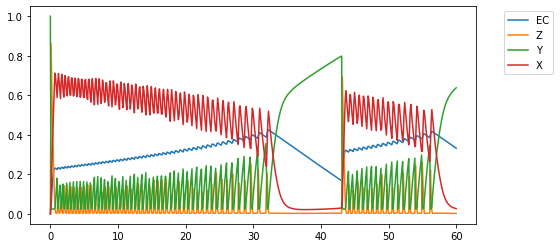

In [14]:
numExperiment = runStudy( isProgressReport=True)

## Studies and Analysis

By choosing a combination of factors at the low and high end of change, the combinatorics were modest.
Changing just Y was sufficient to find a combination of values
that met the requirements of the problem.

760

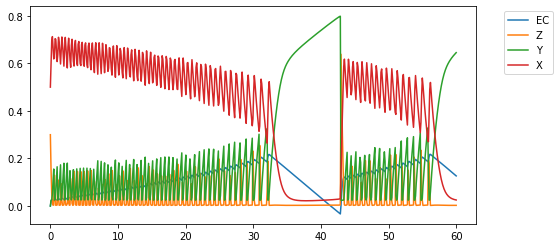

In [17]:
runStudy(isProgressReport=False, isTFC=False)